In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
""" Necessary modules """
from matplotlib.backends.backend_pdf import PdfPages
from Methods.classify import split_data, plotClass, plotClass_separated
from Methods.miasa_class import Miasa_Class

In [3]:
""" Name and origin of dataset """
DataName = "Distribution_data"
from Methods.simulate_class_data import generate_data_dist

In [4]:
""" Euclidean embedding pameters only used in MIASA (includes a finite number of auto adjustements)
    
    if custom, then type dictionary 
    c_dic = {"c1":float, "c2":float, "c3":float} 
"""
c_dic = "default" 

""" Load or Generate data: 
    
    Required:
    X and Y are separated datasets with M, N samples, respectively, with each samples containing K realizations
    X.shape = (M, K) 
    Y.shape = (N, K)
    num_clust = number of clusters
    dtp : tuple (datatype X_vars , datatype Y_vars) is needed for visualization only
    

    Not Required:
    X_vars, Y_vars = Labels of X and Y samples
    Class_True = True cluster labels of samples
    
"""
palette = "Spectral"# seaborn color palette for true clusters (make sure not to use cyclic color maps)
data_dic_orig, class_dic, num_clust, dtp = generate_data_dist(var_data = False, palette = palette)
X, Y, Class_True, X_vars, Y_vars = split_data(data_dic_orig, class_dic, separation = False) # separation = False always for generate_data_dist

In [5]:
"""
Parameters of MIASA
"""

metric_method = ("eCDF", "KS-stat") # (Similarity, Association) distance models
clust_method = "Kmeans" # clustering aglorithm to use
palette = "coolwarm" # seaborn color palette (make sure not to use cyclic color maps)
dist_origin = (True,False) # for datasets (X, Y) decide if the distance to the origin of the axes is interpretable as the norm of the feature representations of the samples
in_threads = False # True to avoid broken runs when using parallel jobs (relevant only for class_experiments)


In [6]:
"""
If desired custom similarity feature representation (defining Euclidean similarity distance) 
and association measures then 

1) set 
    metric_method = "precomputed"
2) give Feature_dic as parameter
    Feature_dic["Feature_X"] : array similarity features of dataset X: M samples and L features, X.shape = (M, L)
    Feature_dic["Feature_Y"] : array similarity features of dataset Y: M samples and S features, Y.shape = (N, S)
    Feature_dic["Asssociation_function"] : a function of argument tuple full datasets (X, Y) or pair of samples (X_i, Y_j) computing the pairwise association between the samples of X and Y
    
    Feature_dic["assoc_func_type"] : type of the association function as options
                                    option 1: str vectorized     : argument full datasets (X, Y) => return directly the Asscociation distance matrix of shape (M, N) 
                                    option 2: str not_vectorized : argument samples (X_i, Y_j)   => return a scalar = Associaiton distance between sample X_i and sample Y_j

    Feature_dic["DMat"]  : array distance function, then Feature_dic["Asssociation_function"] Feature_dic["assoc_func_type"] can be set to None 
    Feature_dic["dist_origin"]: bool tuple (X?, Y?) deciding if the distance to the origin of the axes is interpretable as the norm of the feature representations of the samples
                                Must be in aggreement with given Feature_dic["DMat"]
                                if any (X?, Y?) then shape Feature_dic["DMat"].shape = (M+N+1, M+N+1) and distance to origin is placed at the M+1-th row (see function Methods.Core.CosLM.Prox_Mat)

example:
    
from Methods.Generate_Features import eCDF, get_assoc_func
metric_method = "precomputed"
Feature_dic = {} 
Feature_dic["Feature_X"], Feature_dic["Feature_Y"] = eCDF(X,Y)
Feature_dic["Asssociation_function"], Feature_dic["assoc_func_type"] = get_assoc_func("KS-stat")
Feature_dic["DMat"] = None 
Feature_dic["dist_origin"] = (True,False) ## Only used if DMat is not None and contain distance to origin setting 
"""
Feature_dic = None

In [7]:
""" 
Perform MIASA Classification of samples

"""
Id_Class = Miasa_Class(X, Y, num_clust, 
                       dist_origin = dist_origin, 
                       metric_method = metric_method, 
                       clust_method = clust_method, 
                       c_dic = c_dic, Feature_dic = Feature_dic,
                       in_threads = in_threads,
                       palette = palette)

import numpy as np
import pandas as pd
print("------------- Some checking ------------")
print("Number of True Clusters/Distributions", len(np.unique(Class_True)), "checked:", num_clust == len(np.unique(Class_True)))
num_col_true = (np.unique(pd.DataFrame(data_dic_orig["true_colors"]).loc[:][:], axis = 1)).shape[1]
print("Number of True colors of clusters", num_col_true, "checked non-cyclic:", num_col_true == num_clust) 

print("Number of predicted clusters", len(np.unique(Id_Class["Class_pred"])), "checked:", num_clust == len(np.unique(Id_Class["Class_pred"])))
num_col_pred = (np.unique(Id_Class["color_clustered"], axis = 0)).shape[0]
print("Number of colors predicted clusters", num_col_pred, "checked non-cyclic:", num_col_pred == num_clust) 


Replacement matrix is PSD: success Euclidean embedding
------------- Some checking ------------
Number of True Clusters/Distributions 40 checked: True
Number of True colors of clusters 40 checked non-cyclic: True
Number of predicted clusters 40 checked: True
Number of colors predicted clusters 40 checked non-cyclic: True


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


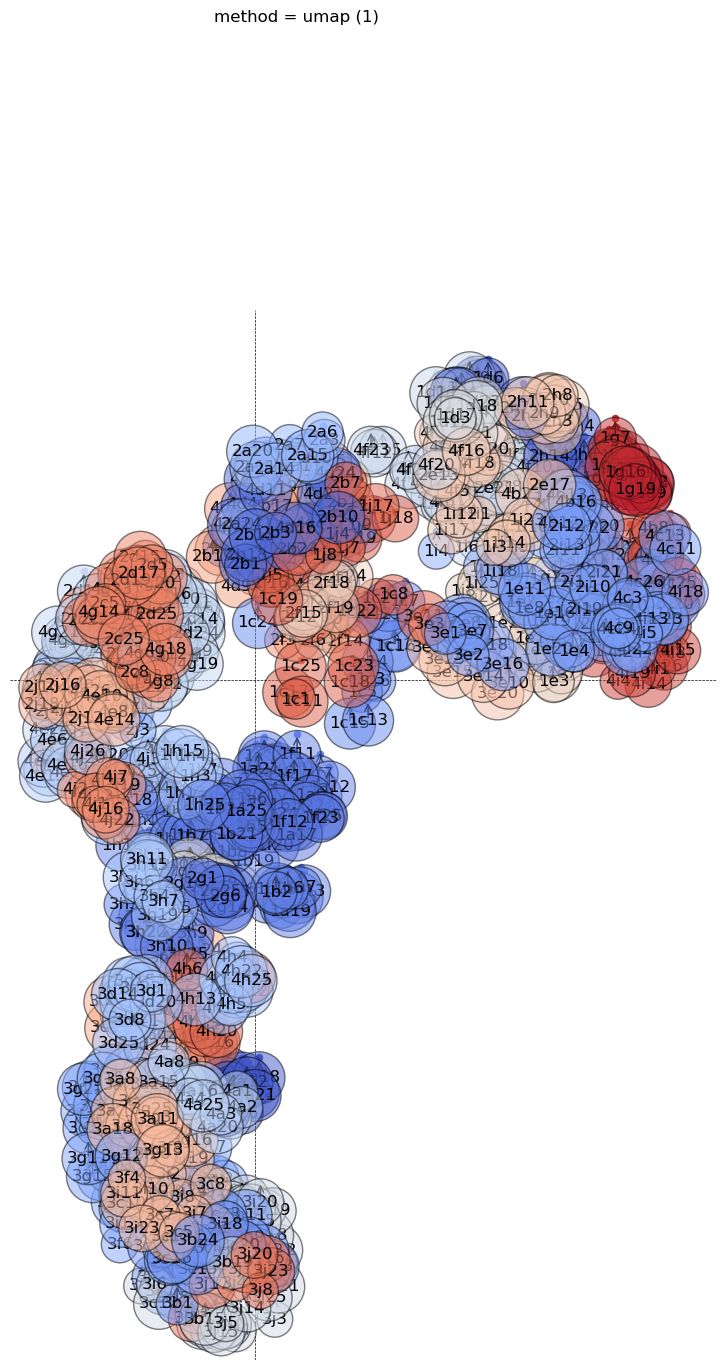

In [8]:
"""Lower Dimensional visualization of clusters (UMAP visualization) - all classes - colored predicted classes"""
pdf= PdfPages("Figures/"+DataName+"_UMAP.pdf")
plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, min_dist = 0.99, 
          method = "umap", scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = True, # chosed_color: if False, true_colors bellow must be given 
          true_colors = None,# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",20),("o",20)], # optional markers list and their size for X and Y
          show_labels = True, # optional show the labels of X and Y
          show_orig = True)# optional show the the axis lines going through origin 
#pdf.close()
import matplotlib.pyplot as plt
plt.show()

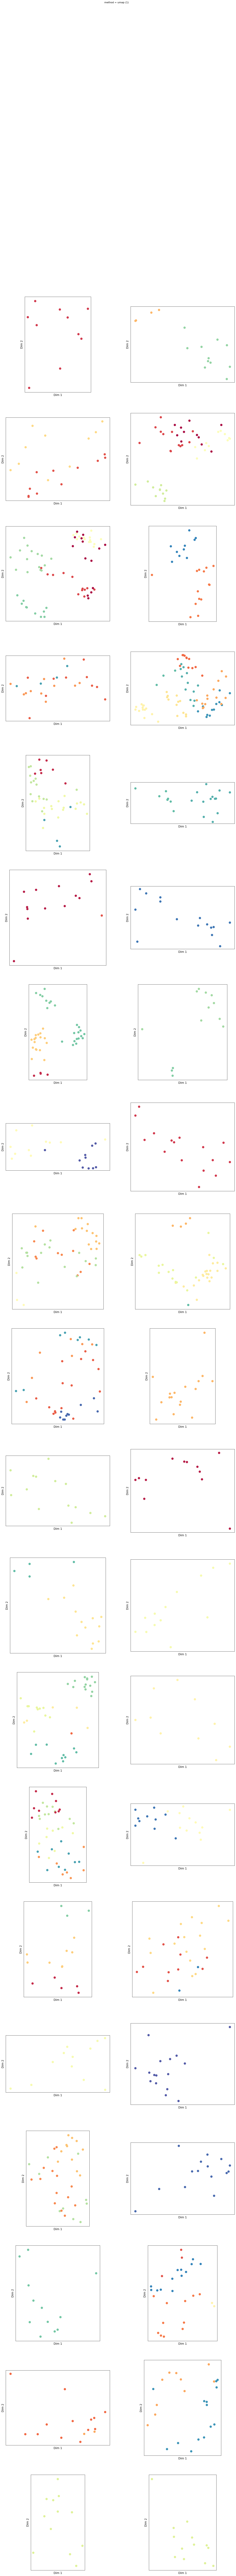

In [9]:
"""Lower Dimensional visualization of clusters (UMAP visualization) - separated classes - colored true classes"""
plotClass_separated(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, min_dist = 0.99, 
          method = "umap", scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("o",100)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin 
          show_separation = True, # optional separate all subfigs
          num_row_col = (20, 2) )  # number of subfigs in row and col
pdf.close() # save everything                

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


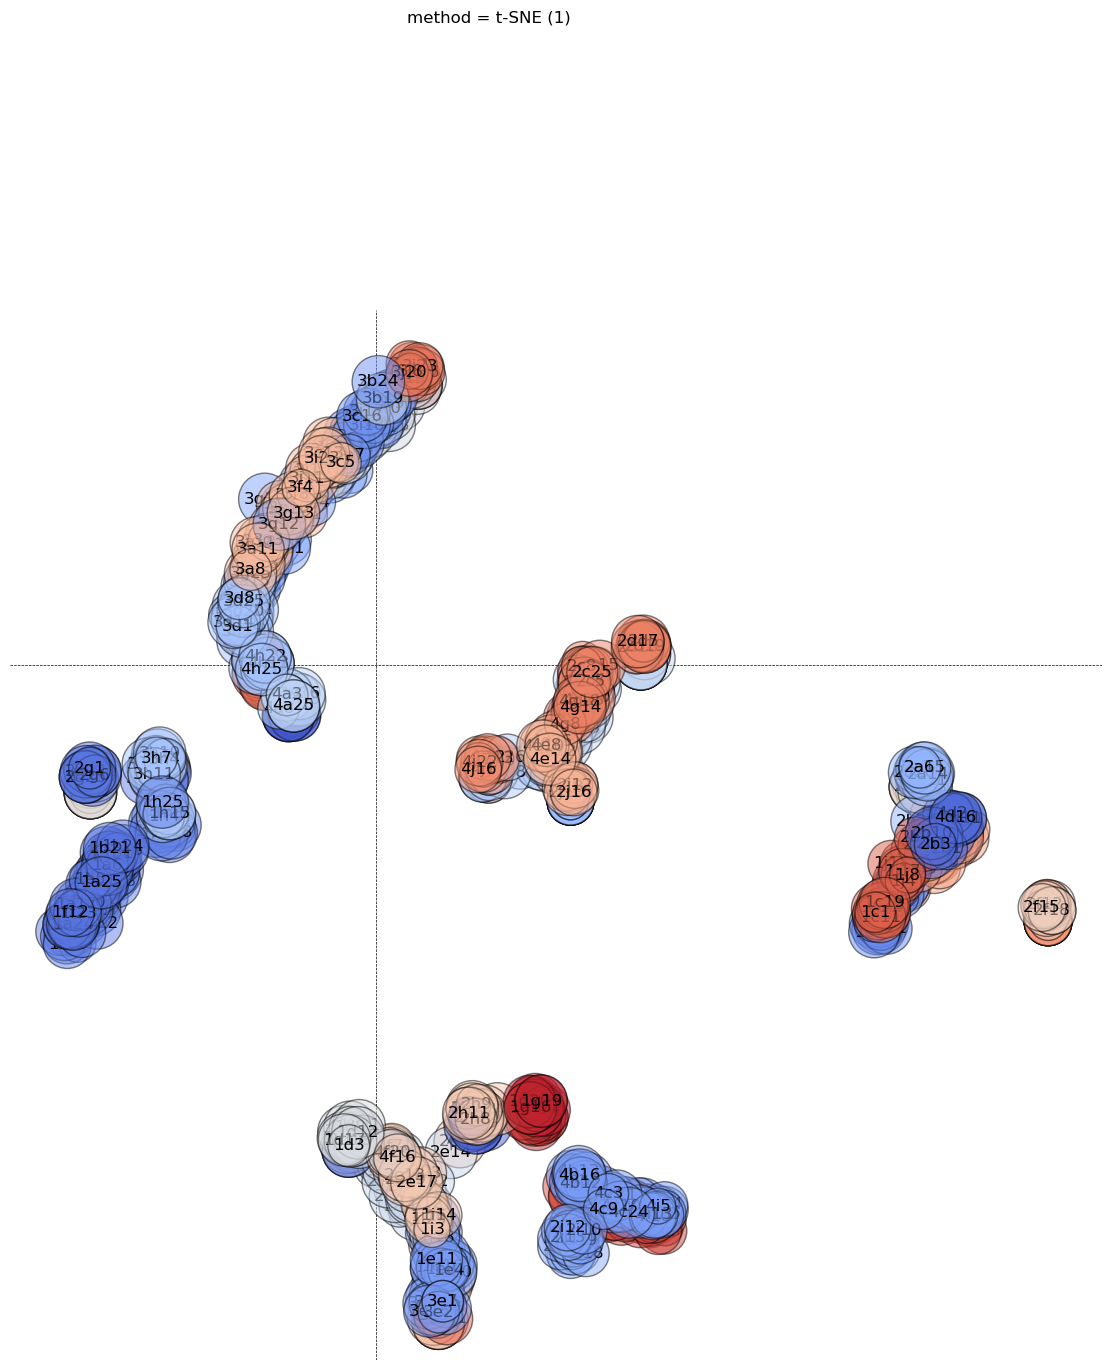

In [10]:
"""Lower Dimensional visualization of clusters (TSNE visualization) - all classes - colored predicted classes """
pdf= PdfPages("Figures/"+DataName+"_TSNE.pdf")
plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 30, 
          method = "t-SNE", scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = True, # chosed_color: if False, true_colors bellow must be given 
          true_colors = None,# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",20),("o",20)], # optional markers list and their size for X and Y
          show_labels = True, # optional show the labels of X and Y
          show_orig = True)# optional show the the axis lines going through origin 
#pdf.close()
import matplotlib.pyplot as plt
plt.show()

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


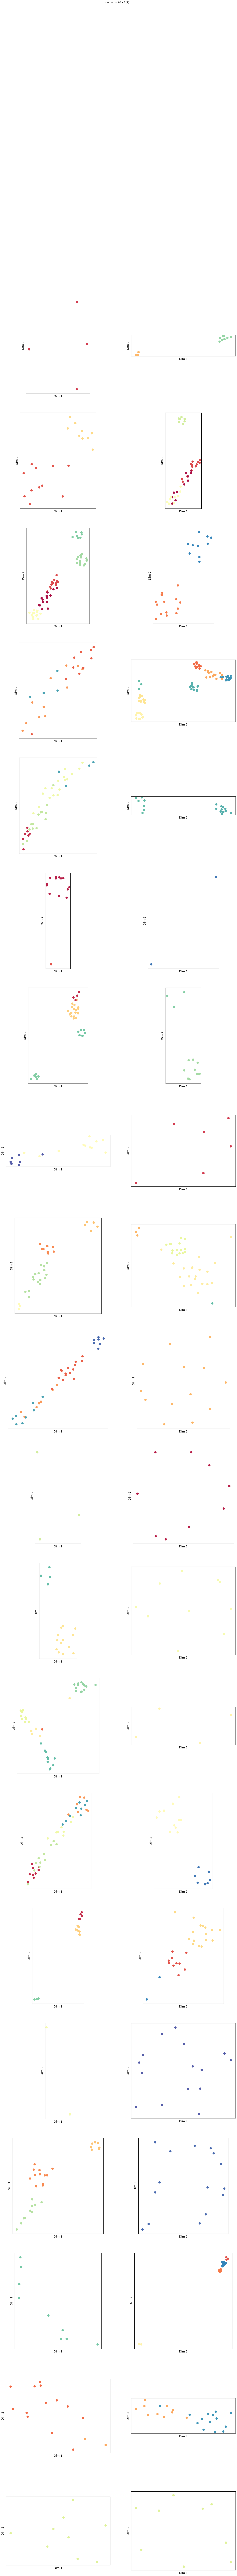

In [11]:
"""Lower Dimensional visualization of clusters (TSNE visualization) - separated classes -- colored true classes"""
plotClass_separated(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 30, 
          method = "t-SNE", scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("o",100)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin
           show_separation = True, # optional separate all subfigs
          num_row_col = (20, 2) )  # number of subfigs in row and col
pdf.close() # save everything                
plt.show()